In [69]:
%reload_ext autoreload
%autoreload 2

# Imports

In [70]:
from kret_notebook import *  # NOTE import first
from kret_matplotlib.mpl_nb_imports import *
from kret_np_pd.np_pd_nb_imports import *
from kret_polars.polars_nb_imports import *
from kret_rosetta.rosetta_nb_imports import *
from kret_lgbm.lgbm_nb_imports import *
from kret_sklearn.sklearn_nb_imports import *
from kret_torch_utils.torch_nb_imports import *
from kret_lightning.lightning_nb_imports import *
from kret_tqdm.tqdm_nb_imports import *
from kret_type_hints.types_nb_imports import *
from kret_utils.utils_nb_imports import *

# from kret_wandb.wandb_nb_imports import *  # NOTE this is slow to import

# Load Data

In [101]:
df = pd.read_csv(UKS_CONSTANTS.DATA_DIR / "medical_cost.csv")

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Id        1338 non-null   int64  
 1   age       1338 non-null   int64  
 2   sex       1338 non-null   object 
 3   bmi       1338 non-null   float64
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


In [103]:
dtt(df)

,Id,age,sex,bmi,children,smoker,region,charges
,int64,int64,object,float64,int64,object,object,float64
126,127,19,female,28.300,0,yes,southwest,17081.080
215,216,41,female,37.100,2,no,southwest,7371.772
343,344,63,male,36.765,0,no,northeast,13981.850
1044,1045,55,male,35.245,1,no,northeast,11394.066
1209,1210,59,male,37.100,1,no,southwest,12347.172


## Cleanup

In [104]:
UKS_NP_PD.data_cleanup(df)

In [105]:
dtt(df)

,Id,age,sex,bmi,children,smoker,region,charges
,category,int64,category,float64,int64,bool,category,float64
41,42,31,female,36.630,2,False,southeast,4949.759
308,309,58,male,34.865,0,False,northeast,11944.594
541,542,20,female,31.790,2,False,southeast,3056.388
844,845,53,male,30.495,0,False,northeast,10072.055
870,871,50,male,36.200,0,False,southwest,8457.818


In [106]:
df.drop(["Id"], inplace=True, axis=1)

In [107]:
features = df.drop("charges", axis=1)
target = df["charges"]

x_train, x_val, y_train, y_val = train_test_split(features, target, test_size=0.15, random_state=0)

## Scaler & OLS

In [108]:
dtt(features)

,age,sex,bmi,children,smoker,region
,int64,category,float64,int64,bool,category
175,63,female,37.700,0,True,southwest
290,28,female,33.400,0,False,southwest
770,61,male,36.100,3,False,southwest
894,62,male,32.110,0,False,northeast
1014,38,female,27.600,0,False,southwest


In [109]:
float_cols = ["age", "bmi", "children"]
cat_cols = ["sex", "region"]

In [110]:
power_transformer = PowerTransformer(method="yeo-johnson", standardize=True)


column_transform = ColumnTransformer(
    transformers=[
        ("scaler", power_transformer, float_cols),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
    verbose=True,
)

In [111]:
steps = [("column_transform", column_transform)]

In [112]:
pipeline_x = PipelinePD(steps=steps)

In [113]:
x_train = pipeline_x.fit_transform_df(x_train)
x_val = pipeline_x.transform_df(x_val)

[ColumnTransformer] ........ (1 of 2) Processing scaler, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s


In [114]:
x_train_with_dummy = pd.get_dummies(x_train, columns=cat_cols)
x_val_with_dummy = pd.get_dummies(x_val, columns=cat_cols)
dtt([x_train_with_dummy, x_val_with_dummy], n=2)

,age,bmi,children,smoker,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest
,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool
1204,-1.605,-0.513,1.367,True,True,False,False,False,True,False
543,1.046,2.433,-1.072,True,True,False,False,False,True,False
,age,bmi,children,smoker,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest
,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool
436,-1.246,0.225,-1.072,False,False,True,True,False,False,False
477,-0.993,0.824,-1.072,False,False,True,False,True,False,False


In [115]:
ols = LinearRegression()
ols.fit(x_train_with_dummy, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [122]:
resid_train = y_train - ols.predict(x_train_with_dummy)
y_hat_ols = ols.predict(x_val_with_dummy)
resid_val = y_val - y_hat_ols

In [ ]:
dtt([x_train, x_val, resid_train, resid_val], n=2)

age 
 bmi 
 children 
 sex 
 smoker 
 region 
 
 
 
 float64 
 float64 
 float64 
 category 
 bool 
 category 
 
 
 
 
 814 
 -0.149 
 0.644 
 0.961 
 male 
 False 
 southeast 
 
 
 948 
 0.270 
 0.149 
 -1.072 
 male 
 False 
 northwest 
 
 
 
 
 
 
 age 
 bmi 
 children 
 sex 
 smoker 
 region 
 
 
 
 float64 
 float64 
 float64 
 category 
 bool 
 category 
 
 
 
 
 486 
 1.046 
 -1.590 
 1.367 
 female 
 False 
 northwest 
 
 
 310 
 0.795 
 -0.632 
 -1.072 
 male 
 False 
 southwest 
 
 
 
 
 
 
 charges 
 
 
 
 float64 
 
 
 
 
 814 
 -3672.804 
 
 
 948 
 -2894.035 
 
 
 
 
 
 
 charges 
 
 
 
 float64 
 
 
 
 
 486 
 2883.221 
 
 
 310 
 -522.449

## Build LGBM Dataset

In [124]:
x_train_ds = DatasetLGBM(
    x_train,
)

In [125]:
x_train_ds.set_categorical_feature(cat_cols)

In [126]:
# ds_params = {
#     "feature_name": list(X_train.columns),
#     "categorical_feature": cat_cols,
# }
# train_data = lgbm.Dataset(X_train, label=Y_train, **ds_params)
# test_data = lgbm.Dataset(X_val, label=Y_val, reference=train_data, **ds_params)
# train_data.get_feature_name()
# Implementation

## Train Model

In [127]:
raise ValueError("Stop")

ValueError: Stop

In [128]:
LGBM_Defaults.LGBM_REGRESSOR_DEFAULTS

{'boosting_type': 'gbdt',
 'objective': 'regression',
 'num_leaves': 31,
 'max_depth': 7,
 'learning_rate': 0.1,
 'reg_alpha': 0.001,
 'reg_lambda': 0.001,
 'n_jobs': -2,
 'bagging_fraction': 0.85,
 'feature_fraction': 0.85,
 'min_data_in_leaf': 10}

In [129]:
model = LGBMRegressor(**LGBM_Defaults.LGBM_REGRESSOR_DEFAULTS)

In [130]:
fit_defaults = LGBM_Defaults.LGBM_FIT_DEFAULTS
fit_defaults

{'eval_metric': 'l2',
 'callbacks': [<lightgbm.callback._EarlyStoppingCallback at 0x11333f050>,
  <lightgbm.callback._RecordEvaluationCallback at 0x144dcef90>]}

In [ ]:
model.fit(
    x_train, resid_train, eval_set=[(x_val, resid_val)], categorical_feature=cat_cols, **LGBM_Defaults.LGBM_FIT_DEFAULTS
)

Training until validation scores don't improve for 50 rounds
[10]	valid_0's l2: 2.48428e+07
[20]	valid_0's l2: 1.93112e+07
[30]	valid_0's l2: 1.79015e+07
[40]	valid_0's l2: 1.76964e+07
[50]	valid_0's l2: 1.76771e+07
[60]	valid_0's l2: 1.77122e+07
[70]	valid_0's l2: 1.77935e+07
[80]	valid_0's l2: 1.79661e+07
Early stopping, best iteration is:
[34]	valid_0's l2: 1.76753e+07


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,7
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [132]:
LGBM_Defaults.EVAL_RECORDS

{'valid_0': OrderedDict([('l2',
               [np.float64(35088309.34034522),
                np.float64(31671125.614446037),
                np.float64(31536520.55370697),
                np.float64(31466926.007296216),
                np.float64(28771960.459953286),
                np.float64(26756712.6254697),
                np.float64(26616773.829073362),
                np.float64(26607622.216208704),
                np.float64(26566709.442738775),
                np.float64(24842795.918248195),
                np.float64(23408881.458775613),
                np.float64(23324029.406817395),
                np.float64(22155213.74234047),
                np.float64(22105700.600752),
                np.float64(21960539.68211287),
                np.float64(21226640.44655968),
                np.float64(20463139.489424024),
                np.float64(20435125.349587463),
                np.float64(19802264.932298698),
                np.float64(19311178.97142271),
                np.

In [133]:
# model = lgb.train(
#     params=LGBM_Defaults.LGBM_REGRESSOR_DEFAULTS,  # type:ignore[arg-type]
#     train_set=train_data,
#     valid_sets=[test_data],
#     num_boost_round=1000,
#     callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=100)],
# )

# NOTE ^ bad performance

In [ ]:
y_pred_resid = model.predict(x_val)
y_hat = y_pred_resid + y_hat_ols

In [138]:
gs = GroupScatterUKS(y_val, y_pred)

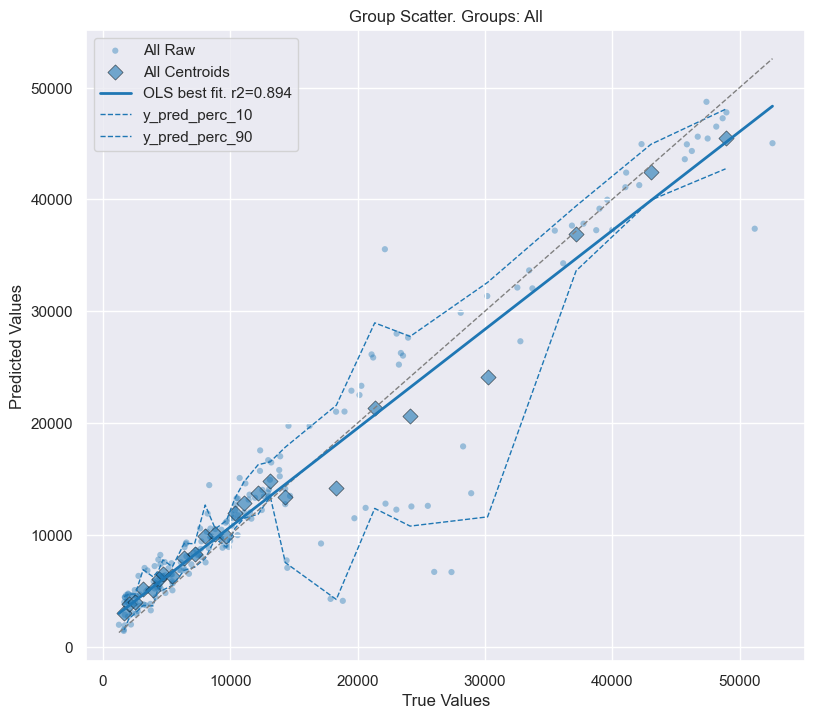

In [139]:
gs.plot(scatters=("raw", "centroids"), percentiles=(10, 90))

# Sandbox

In [140]:
gs_resid = GroupScatterUKS(resid_val, y_pred_resid)

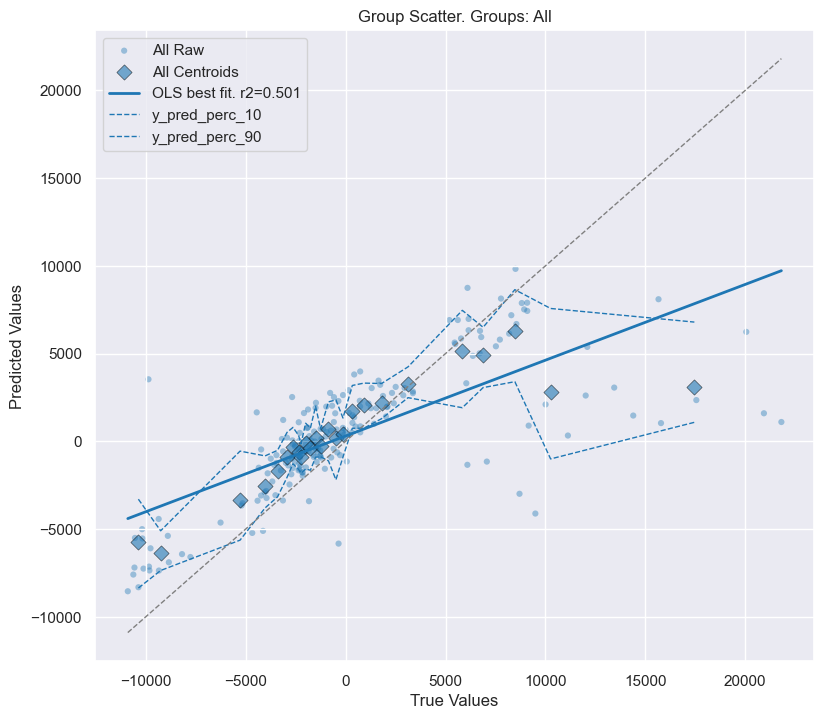

In [141]:
gs_resid.plot(scatters=("raw", "centroids"), percentiles=(10, 90))